In [1]:
%reset -f

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import sys
import os
import glob
sys.path.append(os.path.abspath('../../Code/Software/CarDpy-master'))
from cardpy.Sample_Data.Data_Paths import *
from cardpy.Data_Import            import *
from cardpy.Data_Sorting           import *
from cardpy.Data_Processing.DTI    import *
from cardpy.GUI_Tools              import IntERCOMS
from cardpy.Colormaps              import *
from cardpy.Data_Saving            import *
from cardpy.Data_Processing.cDTI   import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import nrrd

cDTI_cmaps     = cDTI_Colormaps_Generator()

In [11]:
volunteer = '/V001'
res = '/vol_2.0res_3.0sl'

main_path                = os.path.abspath('../../Data/NifTi'+volunteer+res+'/ADC_Filtered')
NifTi_path               = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]

Segmentation_Path        = os.path.join(os.path.abspath('../../Data/Segmentations'+volunteer+res),'Interpolated_mask.mat')
#if os.path.isdir(Segmentation_Path) == False:
#    os.makedirs(Segmentation_Path)
Quantiative_Results_Path = os.path.join(os.path.abspath('../../Data/DTI_Maps'+volunteer+res+'/ADC_Filtered'))
if os.path.isdir(Quantiative_Results_Path) == False:
    os.makedirs(Quantiative_Results_Path)

[matrix_stacked, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
[matrix_sorted,  b_vals_sorted,  b_vecs_sorted]                = stacked2sorted(matrix_stacked, b_vals_stacked, b_vecs_stacked)
[_, _, Eigenvectors, Standard_DTI_Metrics]                     = DTI_recon(matrix_sorted, b_vals_sorted, b_vecs_sorted, tensor_fit = 'NLLS')
#[Endo_Centers, Endo_Axes, Epi_Centers, Epi_Axes]               = IntERCOMS.IntERCOMS_GUI(matrix_sorted[:, :, :, 0], Standard_DTI_Metrics['MD'], Eigenvectors['E1'], Line_Width = 1)
#[myocardium_mask, NRRD2, NRRD1]                                = IntERCOMS.IntERCOMS_Mask_Making(matrix_sorted, Endo_Centers, Endo_Axes, Epi_Centers, Epi_Axes)
#Save_NRRD_Segmentation(NRRD1, Header, Segmentaiton_Path, 'LV_Blood_Pool')
#Save_NRRD_Segmentation(NRRD2, Header, Segmentaiton_Path, 'LV_Myocardium+Blood_Pool')
myocardium_mask = scipy.io.loadmat(glob.glob(Segmentation_Path)[0])['Mask']

myocardial_mask              = myocardium_mask
# image = myocardial_mask
num_interp_points            = 200
smoothness_level             = 'Medium'
Helix_Angle_Filter_Settings  = dict()
Helix_Angle_Filter_Settings['Linear Filter: Outlier StDev']      = 1
Helix_Angle_Filter_Settings['Spatial Filter: Wall Depth Factor'] = 0.25
Helix_Angle_Filter_Settings['Spatial Filter: Kernel Size']       = 5

[Cardiac_DTI_Metrics, Epi, Endo, Mask] = cDTI_recon(myocardial_mask, Eigenvectors, num_interp_points, smoothness_level, Helix_Angle_Filter_Settings)

myocardial_mask_smoothed = np.copy(Mask)
myocardial_mask_smoothed_nan = np.copy(myocardial_mask_smoothed)
myocardial_mask_smoothed_nan = myocardial_mask_smoothed_nan.astype('float')
myocardial_mask_smoothed_nan [myocardial_mask_smoothed_nan == 0] = np.nan

grid     = Endo2Epi_Grid(myocardial_mask_smoothed)
grid_nan = np.copy(grid)
grid_nan = grid_nan * myocardial_mask_smoothed_nan
grid_nan = np.clip(grid_nan, 0.0, 1)
matrix   = matrix_sorted

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dipy/reconst/dti.py:498: RuntimeWarning: invalid value encountered in divide
  return 3 * np.sqrt(6) * determinant((A_squiggle / A_s_norm))


Autoadjust Epicardium
Autoadjust Epicardium
Autoadjust Endocardium
Autoadjust Endocardium


Slice 1 of 1


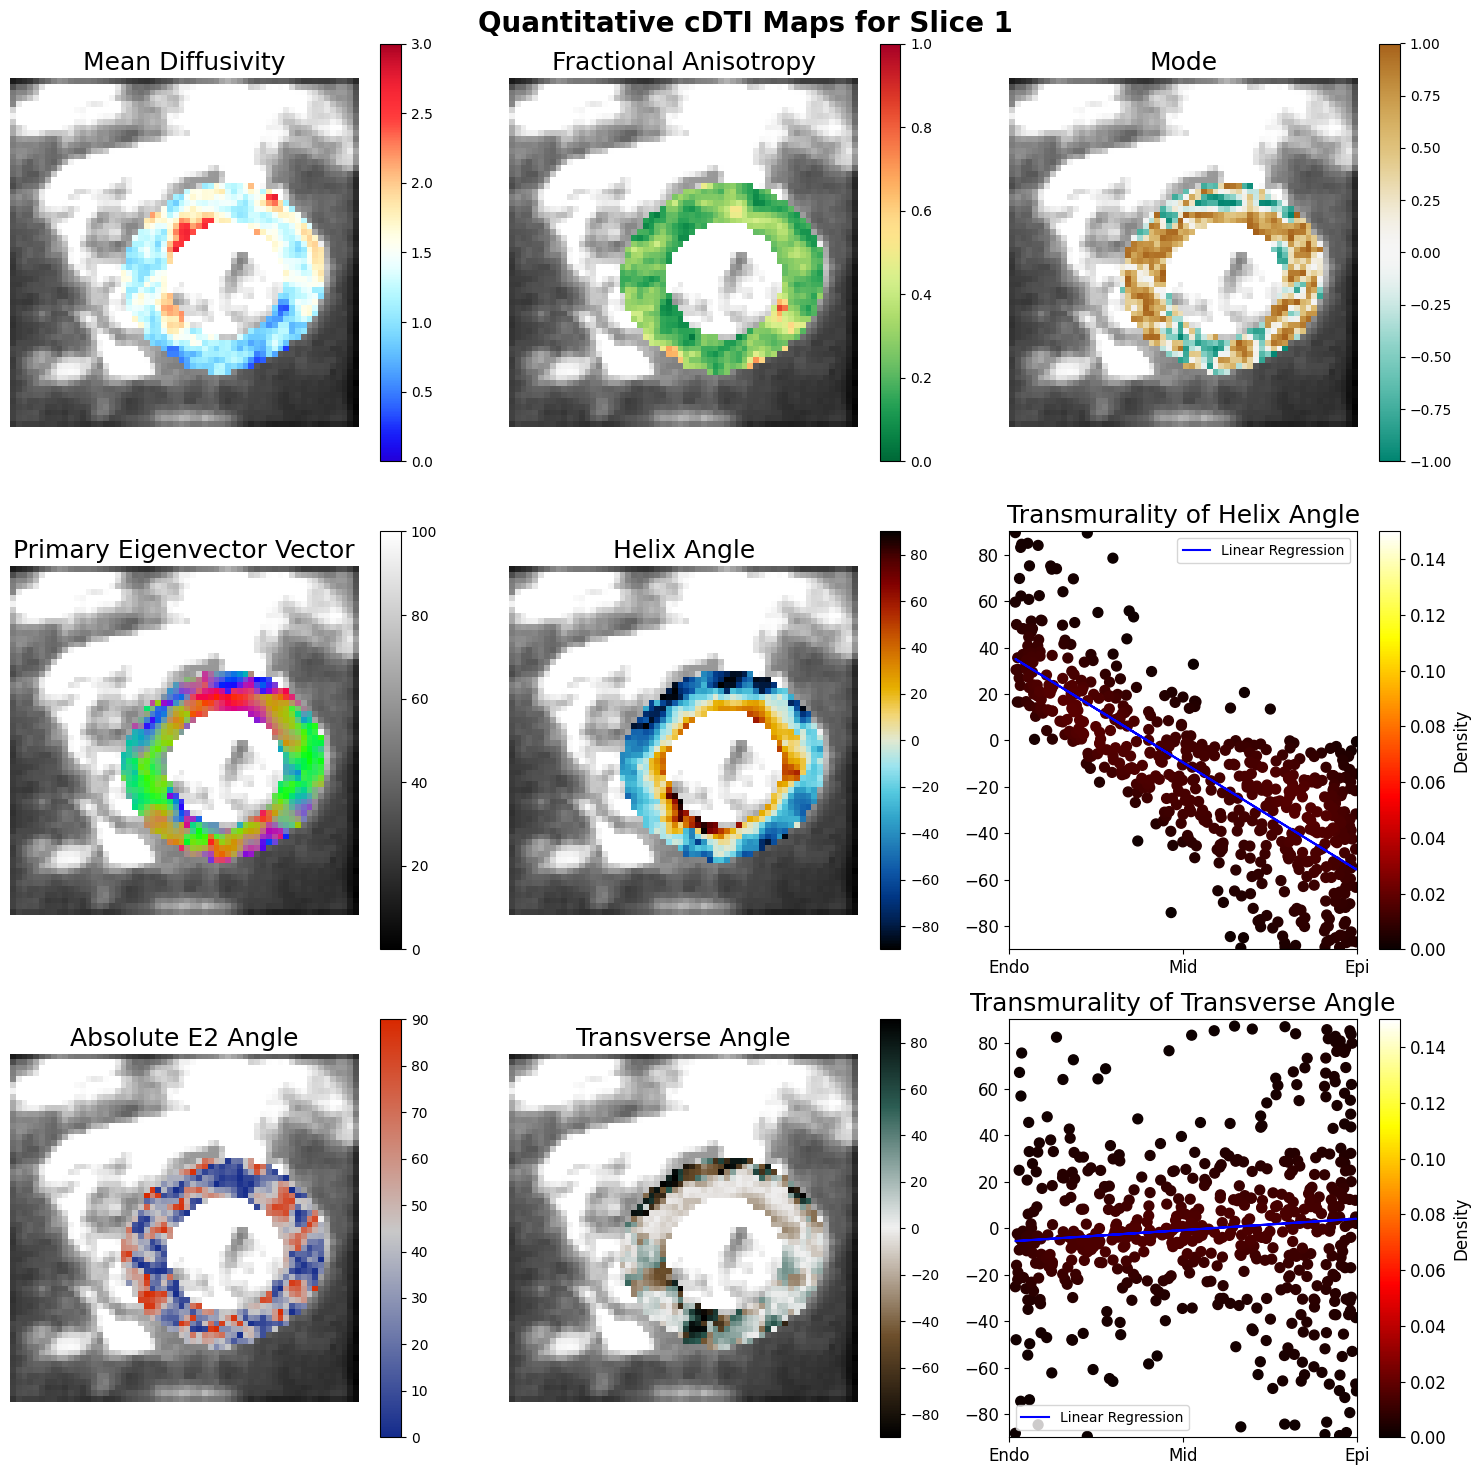

In [12]:
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression

x_tick_labels = ['Endo', 'Mid', 'Epi']
x_tick_values = [0, 0.5, 1.0]

slc = 0
vmax_image = 100
main_maps_outpath = Quantiative_Results_Path

for slc in range(myocardial_mask_smoothed_nan.shape[2]):
    
    print('Slice %i of %i' %(slc + 1, myocardial_mask_smoothed_nan.shape[2]))
    fig = plt.figure(figsize = (15, 15), dpi= 100)
    fig.patch.set_facecolor('white')
    fig.suptitle('Quantitative cDTI Maps for Slice %i' %(slc + 1), fontsize = 20, fontweight='bold')
    plt.subplot(3,3,1)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Standard_DTI_Metrics['MD'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = 0, vmax = 3, cmap = cDTI_cmaps['MD'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Mean Diffusivity', fontsize = 18)

    plt.subplot(3,3,2)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Standard_DTI_Metrics['FA'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = 0, vmax = 1, cmap = cDTI_cmaps['FA'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Fractional Anisotropy', fontsize = 18)

    plt.subplot(3,3,3)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Standard_DTI_Metrics['MO'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = -1, vmax = 1, cmap = cDTI_cmaps['MO'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Mode', fontsize = 18)

    plt.subplot(3,3,4)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.colorbar()
    tmp1 = np.expand_dims(myocardial_mask_smoothed_nan[:, :, slc], axis = 2)
    tmp2 = abs(Eigenvectors['E1'][:, :, slc, :])
    tmp3 = np.concatenate((tmp2, tmp1), axis = 2)
    plt.imshow(tmp3, interpolation = 'nearest')
    plt.axis('off')
    plt.title('Primary Eigenvector Vector', fontsize = 18)

    plt.subplot(3,3,5)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Cardiac_DTI_Metrics['HASF'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = -90, vmax = 90, cmap = cDTI_cmaps['HA'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Helix Angle', fontsize = 18)
    
    plt.subplot(3,3,6)
    
    E2E_data = grid_nan[:, :, slc].flatten()
    E2E_data = E2E_data[~(np.isnan(grid_nan[:, :, slc].flatten()))]
    x = E2E_data
    xi = np.copy(x)

    HA_data  = Cardiac_DTI_Metrics['HASF'][:, :, slc].flatten()
    HA_data  = HA_data[~(np.isnan(grid_nan[:, :, slc].flatten()))]
    y = HA_data
    yi = np.copy(y)

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    density = plt.scatter(x, y, c=z, s=50, cmap = 'hot')


    model                 = LinearRegression().fit(x[:, np.newaxis], y[:, np.newaxis])
    y_predicted = model.intercept_ + model.coef_ * x[:, np.newaxis]
    
    plt.plot(x[:, np.newaxis], y_predicted, 'b-', label = 'Linear Regression')
    plt.legend()
    
    plt.title('Transmurality of Helix Angle', fontsize = 18)
    plt.xticks(x_tick_values, x_tick_labels, fontsize = 12)
    plt.yticks(fontsize = 12)
    cbar = plt.colorbar(density)
    cbar.set_label(label='Density', fontsize = 12)
    cbar.ax.tick_params(labelsize = 12)
    plt.clim([0, 0.15])
    # fig.colorbar.tick_params(labelsize=10)
    plt.ylim([-90, 90])
    plt.xlim([0, 1])

    plt.subplot(3,3,7)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Cardiac_DTI_Metrics['E2A'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = 0, vmax = 90, cmap = cDTI_cmaps['absE2A'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Absolute E2 Angle', fontsize = 18)

    plt.subplot(3,3,8)
    plt.imshow(matrix[:, :, slc, 0], vmin = 0, vmax = vmax_image, cmap = 'gray')
    plt.imshow(Cardiac_DTI_Metrics['TA'][:, :, slc] * myocardial_mask_smoothed_nan[:, :, slc], vmin = -90, vmax = 90, cmap = cDTI_cmaps['TA'], interpolation = 'nearest')
    plt.axis('off')
    plt.colorbar()
    plt.title('Transverse Angle', fontsize = 18)
    string = 'Quantitative_cDTI_Maps_' + str(slc+1).zfill(2) + ' Slice.png'
    
    plt.subplot(3,3,9)
    x2 = E2E_data
    
    y2 = Cardiac_DTI_Metrics['TA'][:, :, slc].flatten()
    y2 = y2[~(np.isnan(grid_nan[:, :, slc].flatten()))]    

    # Calculate the point density
    xy2 = np.vstack([x2, y2])
    z2 = gaussian_kde(xy2)(xy2)

    # Sort the points by density, so that the densest points are plotted last
    idx = z2.argsort()
    x2, y2, z2 = x2[idx], y2[idx], z2[idx]
    density = plt.scatter(x2, y2, c=z2, s=50, cmap = 'hot')
    
    model                 = LinearRegression().fit(x2[:, np.newaxis], y2[:, np.newaxis])
    y2_predicted = model.intercept_ + model.coef_ * x2[:, np.newaxis]
    
    plt.plot(x2[:, np.newaxis], y2_predicted, 'b-', label = 'Linear Regression')
    plt.legend()
    
    plt.title('Transmurality of Transverse Angle', fontsize = 18)
    plt.xticks(x_tick_values, x_tick_labels, fontsize = 12)
    plt.yticks(fontsize = 12)
    cbar = plt.colorbar(density)
    cbar.set_label(label='Density', fontsize = 12)
    cbar.ax.tick_params(labelsize = 12)
    plt.clim([0, 0.15])
    # fig.colorbar.tick_params(labelsize=10)
    plt.ylim([-90, 90])
    plt.xlim([0, 1])
    
    plt.tight_layout()
    output_path = os.path.join(Quantiative_Results_Path, string)
    plt.savefig(output_path)
    plt.show()

In [13]:
from scipy.io import savemat

data_list   = [Standard_DTI_Metrics, Cardiac_DTI_Metrics, Eigenvectors] 
string_list = ['Standard_DTI_Metrics', 'cDTI_Metrics', 'DTI_Eigenvectors']

for idx in range(len(data_list)):
    string = string_list[idx]
    outpath = os.path.join(Quantiative_Results_Path, string + '.mat')
    savemat(outpath, data_list[idx])

In [14]:
data_list = [{'Mask':myocardial_mask_smoothed_nan}]
string_list = ['Myocardium_Mask_Smoothed']

Segmentation_Save_Path = os.path.join(os.path.abspath('../../Data/Segmentations'+volunteer+res))

for idx in range(len(data_list)):
    string = string_list[idx]
    outpath = os.path.join(Segmentation_Save_Path , string + '.mat')
    savemat(outpath, data_list[idx])


In [15]:
myocardial_mask_smoothed_nan.shape


(60, 60, 1)

In [16]:
output_path

'/Volumes/T7/Voxel_Bank/Data/DTI_Maps/V001/vol_2.0res_3.0sl/ADC_Filtered/Quantitative_cDTI_Maps_01 Slice.png'